## 确定最佳k值

#### 数据准备

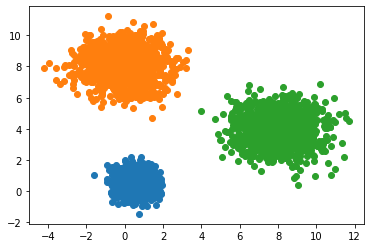

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# 随机生成三组二元正态分布随机数
np.random.seed(1234)
mean1 = [0.5, 0.5]
cov1 = [[0.3, 0], [0, 0.3]]
x1, y1 = np.random.multivariate_normal(mean1, cov1, 1000).T

mean2 = [0, 8]
cov2 = [[1.5, 0], [0, 1]]
x2, y2 = np.random.multivariate_normal(mean2, cov2, 1000).T

mean3 = [8, 4]
cov3 = [[1.5, 0], [0, 1]]
x3, y3 = np.random.multivariate_normal(mean3, cov3, 1000).T

plt.scatter(x1, y1)
plt.scatter(x2, y2)
plt.scatter(x3, y3)
plt.show()

X = pd.DataFrame(np.concatenate([np.array([x1, y1]), np.array([x2, y2]), np.array([x3, y3])], axis=1).T)

### 拐点法

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


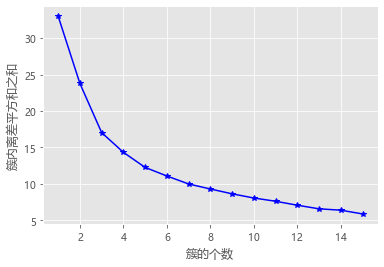

In [6]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
# 构造自定义函数，用于绘制不同k值和对应总的簇内离差平方和的折线图
def k_SSE(X, clusters):
    # 选择连续的K种不同的值
    K = range(1, clusters+1)
    # 构建空列表用于储存总的簇内离差平方和
    TSSE = []
    for k in K:
        # 用于储存各个簇内离差平方和
        SSE = []
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X)
        # 返回簇标签
        labels = kmeans.labels_
        # 返回簇中心
        centers = kmeans.cluster_centers_
        # 计算各簇样本的利差平方和，并保存到列表中
        for label in set(labels):
            SSE.append(np.sum((X.loc[labels == label, ]-centers[label, :])**2))
        # 计算总的簇内平方和
        TSSE.append(np.sum(SSE))
    # 中文和负号的正常显示
    plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
    plt.rcParams['axes.unicode_minus'] = False
    # 设置绘图风格
    plt.style.use('ggplot')
    # 绘制K的个数与TSSE的关系
    plt.plot(K, TSSE, 'b*-')
    plt.xlabel('簇的个数')
    plt.ylabel('簇内离差平方和之和')
    plt.show()
# 自定义函数调用
k_SSE(X, 15)

### 轮廓系数法

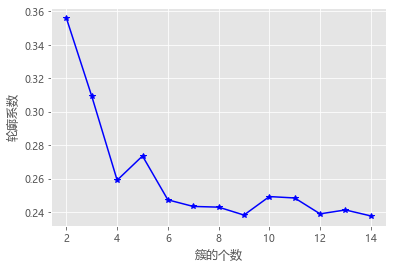

In [7]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import metrics
# 构造自定义函数
def k_silhouette(X, clusters):
    K = range(2, clusters)
    # 构建空列表，用于储存不同簇下的轮廓系数
    S = []
    for k in K:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X)
        labels = kmeans.labels_
        # 调用子模块metrics中的silhouette_score函数，计算轮廓系数
        S.append(metrics.silhouette_score(X, labels, metric='euclidean'))
    # 中文和负号的正常显示
    plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
    plt.rcParams['axes.unicode_minus'] = False
    # 设置绘图风格
    plt.style.use('ggplot')
    # 绘制K的个数与轮廓系数的关系
    plt.plot(K, S, 'b*-')
    plt.xlabel('簇的个数')
    plt.ylabel('轮廓系数')
    plt.show()
# 自定义函数的调用
k_silhouette(X, 15)

### 间隔统计量法

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Window

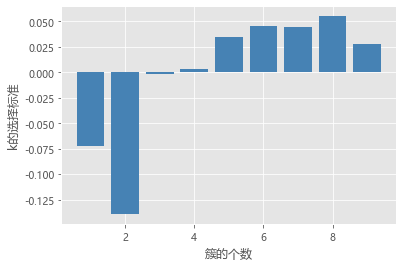

In [8]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import metrics
# 自定义函数，计算簇内任意两样本之间的欧氏距离Dk
def short_pair_wise_D(each_cluster):
    mu = each_cluster.mean(axis=0)
    Dk = sum(sum((each_cluster - mu)**2))*2.0*each_cluster.shape[0]
    return Dk
# 自定义函数，计算簇内的Wk值
def compute_Wk(data, classfication_result):
    Wk = 0
    label_set = set(classfication_result)
    for label in label_set:
        each_cluster = data[classfication_result == label, :]
        Wk = Wk + short_pair_wise_D(each_cluster)/(2.0*each_cluster.shape[0])
    return Wk
# 自定义函数，计算GAP统计量
def gap_statistic(X, B=10, K=range(1, 11), N_init=10):
    # 将输入数据集转换为数组
    X = np.array(X)
    # 生成B组参照数据集
    shape = X.shape
    tops = X.max(axis=0)
    bots = X.min(axis=0)
    dists = np.matrix(np.diag(tops-bots))
    rands = np.random.random_sample(size=(B, shape[0], shape[1]))
    for i in range(B):
        rands[i,:,:] = rands[i,:,:]*dists+bots
    # 自定义0元素的数组，用于储存gaps、Wks和Wkbs
    gaps = np.zeros(len(K))
    Wks = np.zeros(len(K))
    Wkbs = np.zeros((len(K), B))
    # 循环不同的k值，计算各簇下的Wk值
    for idxk, k in enumerate(K):
        k_means = KMeans(n_clusters=k)
        k_means.fit(X)
        classfication_result = k_means.labels_
        # 将所有簇内的Wk存储起来
        Wks[idxk] = compute_Wk(X, classfication_result)
        # 通过循环，计算每一个参照数据集下的各簇Wk值
        for i in range(B):
            Xb = rands[i,:,:]
            k_means.fit(Xb)
            classfication_result_b = k_means.labels_
            Wkbs[idxk, i] = compute_Wk(Xb, classfication_result_b)
    # 计算gaps、sd_ks和gapDiff
    gaps = (np.log(Wkbs)).mean(axis=1)-np.log(Wks)
    sd_ks = np.std(np.log(Wkbs), axis=1)
    sk = sd_ks*np.sqrt(1+1.0/B)
    # 用于判别最佳k的标准，当gapDiff首次为正时，对应的k即为目标值
    gapDiff = gaps[:-1]-gaps[1:]+sk[1:]
    # 中文和负号的正常显示
    plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
    plt.rcParams['axes.unicode_minus'] = False
    # 设置绘图风格
    plt.style.use('ggplot')
    # 绘制gapDiff的条形图
    plt.bar(np.arange(len(gapDiff))+1, gapDiff, color='steelblue')
    plt.xlabel('簇的个数')
    plt.ylabel('k的选择标准')
    plt.show()
gap_statistic(X)

## 鸢尾花类别的聚合

#### 数据准备

In [2]:
import pandas as pd
iris = pd.read_csv("C:/Users/ylc/GitHub/Learning/Python/PyhtonDataMiningFromZero/iris.csv")
iris.head()

,Sepal_Length,Sepal_Width,Petal_Length,Petal_Width,Species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


#### 模型建立

In [3]:
X = iris.drop(labels='Species', axis=1) # 提取出用于建模的数据集X
# 构建KMeans模型
from sklearn import cluster
kmeans = cluster.KMeans(n_clusters=3)
kmeans.fit(X)
X['cluster'] = kmeans.labels_ # 聚类结果标签
X.cluster.value_counts() # 各类频数统计

0    62
1    50
2    38
Name: cluster, dtype: int64

#### 聚类效果与原始类别对比

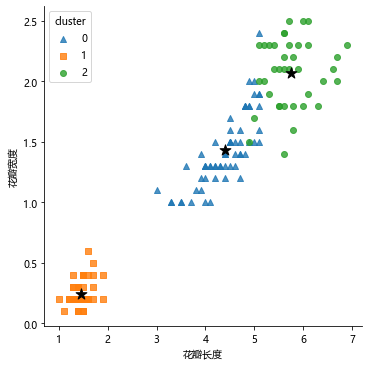

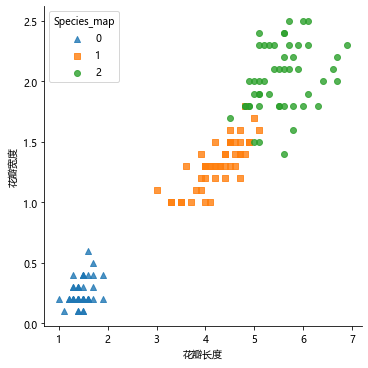

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# 三个簇的簇中心
centers = kmeans.cluster_centers_
# 绘制聚类效果的散点图
# 中文和负号的正常显示
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False
sns.lmplot(x='Petal_Length', y='Petal_Width', hue='cluster', markers=['^', 's', 'o'], data=X, fit_reg=False,
          scatter_kws={'alpha':0.8}, legend_out=False)
plt.scatter(centers[:,2], centers[:,3], marker='*', color='black', s=130)
plt.xlabel('花瓣长度')
plt.ylabel('花瓣宽度')
plt.show()
# 增加一个辅助列，将不同的华中映射到0,1,2三种值，目的是方便后面图形的对比
iris['Species_map'] = iris.Species.map({'setosa':0, 'versicolor':1, 'virginica':2})
# 绘制原始数据三个类别的散点图
sns.lmplot(x='Petal_Length', y='Petal_Width', hue='Species_map', markers=['^', 's', 'o'], data=iris, fit_reg=False,
           scatter_kws={'alpha':0.8}, legend_out=False)
plt.xlabel('花瓣长度')
plt.ylabel('花瓣宽度')
plt.show()

### 基于NBA球员历史参赛数据的聚类

#### 数据准备

In [2]:
import pandas as pd
players = pd.read_csv("C:/Users/ylc/GitHub/Learning/Python/PyhtonDataMiningFromZero/players.csv")
players.head()

,排名,球员,球队,得分,命中-出手,命中率,命中-三分,三分命中率,命中-罚球,罚球命中率,场次,上场时间
0,1,詹姆斯-哈登,火箭,31.9,9.60-21.10,0.454,4.20-10.70,0.397,8.50-9.90,0.861,30,36.1
1,2,扬尼斯-阿德托昆博,雄鹿,29.7,10.90-19.90,0.545,0.50-1.70,0.271,7.50-9.80,0.773,28,38.0
2,3,勒布朗-詹姆斯,骑士,28.2,10.80-18.80,0.572,2.10-5.10,0.411,4.50-5.80,0.775,32,37.3
3,4,斯蒂芬-库里,勇士,26.3,8.30-17.60,0.473,3.60-9.50,0.381,6.00-6.50,0.933,23,32.6
4,4,凯文-杜兰特,勇士,26.3,9.70-19.00,0.510,2.50-6.30,0.396,4.50-5.10,0.879,26,34.8


In [3]:
from sklearn import preprocessing
X = preprocessing.minmax_scale(players[['得分', '罚球命中率', '命中率', '三分命中率']]) # 数据标准化处理
X = pd.DataFrame(X, columns=['得分', '罚球命中率', '命中率', '三分命中率']) # 将数组转化为数据框

#### 确定最佳k值

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


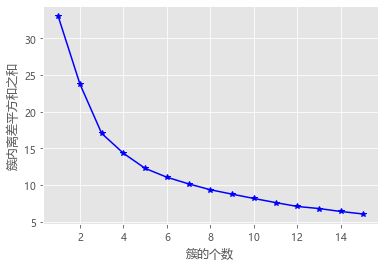

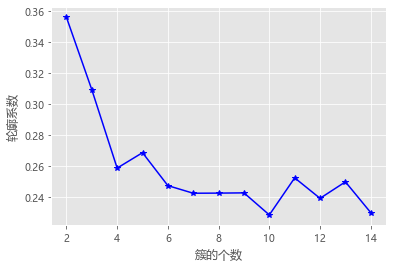

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Window

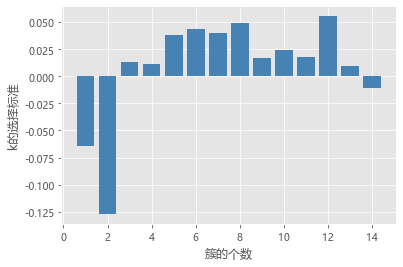

In [9]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import metrics
k_SSE(X, 15) # 调用自定义函数，使用拐点法确定最佳K值
k_silhouette(X, 15) # 调用自定义函数，使用轮廓系数法确定最佳k值
gap_statistic(X, B=20, K=range(1, 16)) # 调用自定义函数，使用间隙统计量选择最佳的k值

#### 建立聚类模型

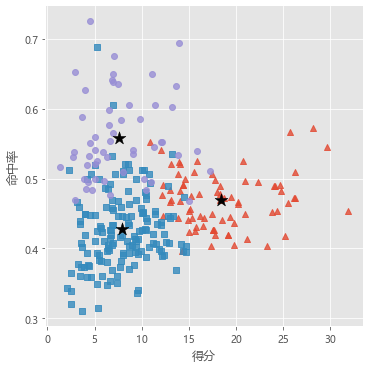

In [18]:
kmeans = KMeans(n_clusters=3) # 将球员聚为3类
kmeans.fit(X)
# 将聚类结果标签插入到数据集players中
players['cluster'] = kmeans.labels_
import numpy as np
# 因为对原始数据进行了标准化处理，所以图中的簇中心不能直接使用cluster_centers_方法获得，因为它返回的是标准化后的值
# 构建空列表，用于存储三个簇的簇中心
centers = []
for i in players.cluster.unique():
    centers.append(players.loc[players.cluster == i, ['得分', '罚球命中率', '命中率', '三分命中率']].mean())
centers = np.array(centers) # 将列表转换为数组，便于之后索引取数

import seaborn as sns    
# 绘制散点图
sns.lmplot(x='得分', y='命中率', hue='cluster', data=players, markers=['^', 's', 'o'],
          fit_reg=False, scatter_kws={'alpha':0.8}, legend=False)
# 添加簇中心
plt.scatter(centers[:,0], centers[:,2], c='k', marker='*', s=180)
plt.xlabel('得分')
plt.ylabel('命中率')
plt.show()